# Well location selection

The oil producing company GlavRosGosNeft needs to decide where to drill a new well.

We were provided with oil samples in three regions: in each 100,000 deposits, where we measured the quality of oil and the volume of its reserves. Let's build a machine learning model that will help determine the region where oil production will bring the most profit. Let's analyze the possible profit and risks using the *Bootstrap.* technique.

Steps to choose a location:

- Determine feature values of each deposit in the selected region;
- Build a model and estimate the volume of reserves;
- Select the deposits with the highest value estimates. The number of fields depends on the company's budget and the cost of developing one well;
- The profit is equal to the total profit of the selected fields.

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

sns.set(style="darkgrid")

In [2]:
region_1 = pd.read_csv('geo_data_0.csv')
region_2 = pd.read_csv('geo_data_1.csv')
region_3 = pd.read_csv('geo_data_2.csv')

### General information

Let's study the quality of the provided exploration data in three regions, and also consider the distributions of the measured values.

In [3]:
def dataset_info(dataset):
    pd.set_option('display.max_columns', None)
    print('\033[1m' + 'GENERAL INFORMATION:' + '\033[0m', end='\n\n')
    dataset.info()
    display(dataset.describe())
    print()
    print('\033[1m' + 'FIRST 10 ROWS:' + '\033[0m')
    display(dataset.head(10))
    print()
    print('\033[1m' + 'DUPLICATES:' + '\033[0m', 
          dataset.duplicated().sum(), end='\n\n')
    print('\033[1m' + 'MISSING VALUES BY COLUMNS:' + '\033[0m', 
          dataset.isna().sum(), sep='\n\n', end='\n\n')
    print('\033[1m' + 'VALUES DISTRIBUTION BY COLUMNS:' + '\033[0m')
    dataset.hist(figsize=(15, 20), bins=20);

#### Region 1

GENERAL INFORMATION:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



FIRST 10 ROWS:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945



DUPLICATES: 0

MISSING VALUES BY COLUMNS:

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

VALUES DISTRIBUTION BY COLUMNS:


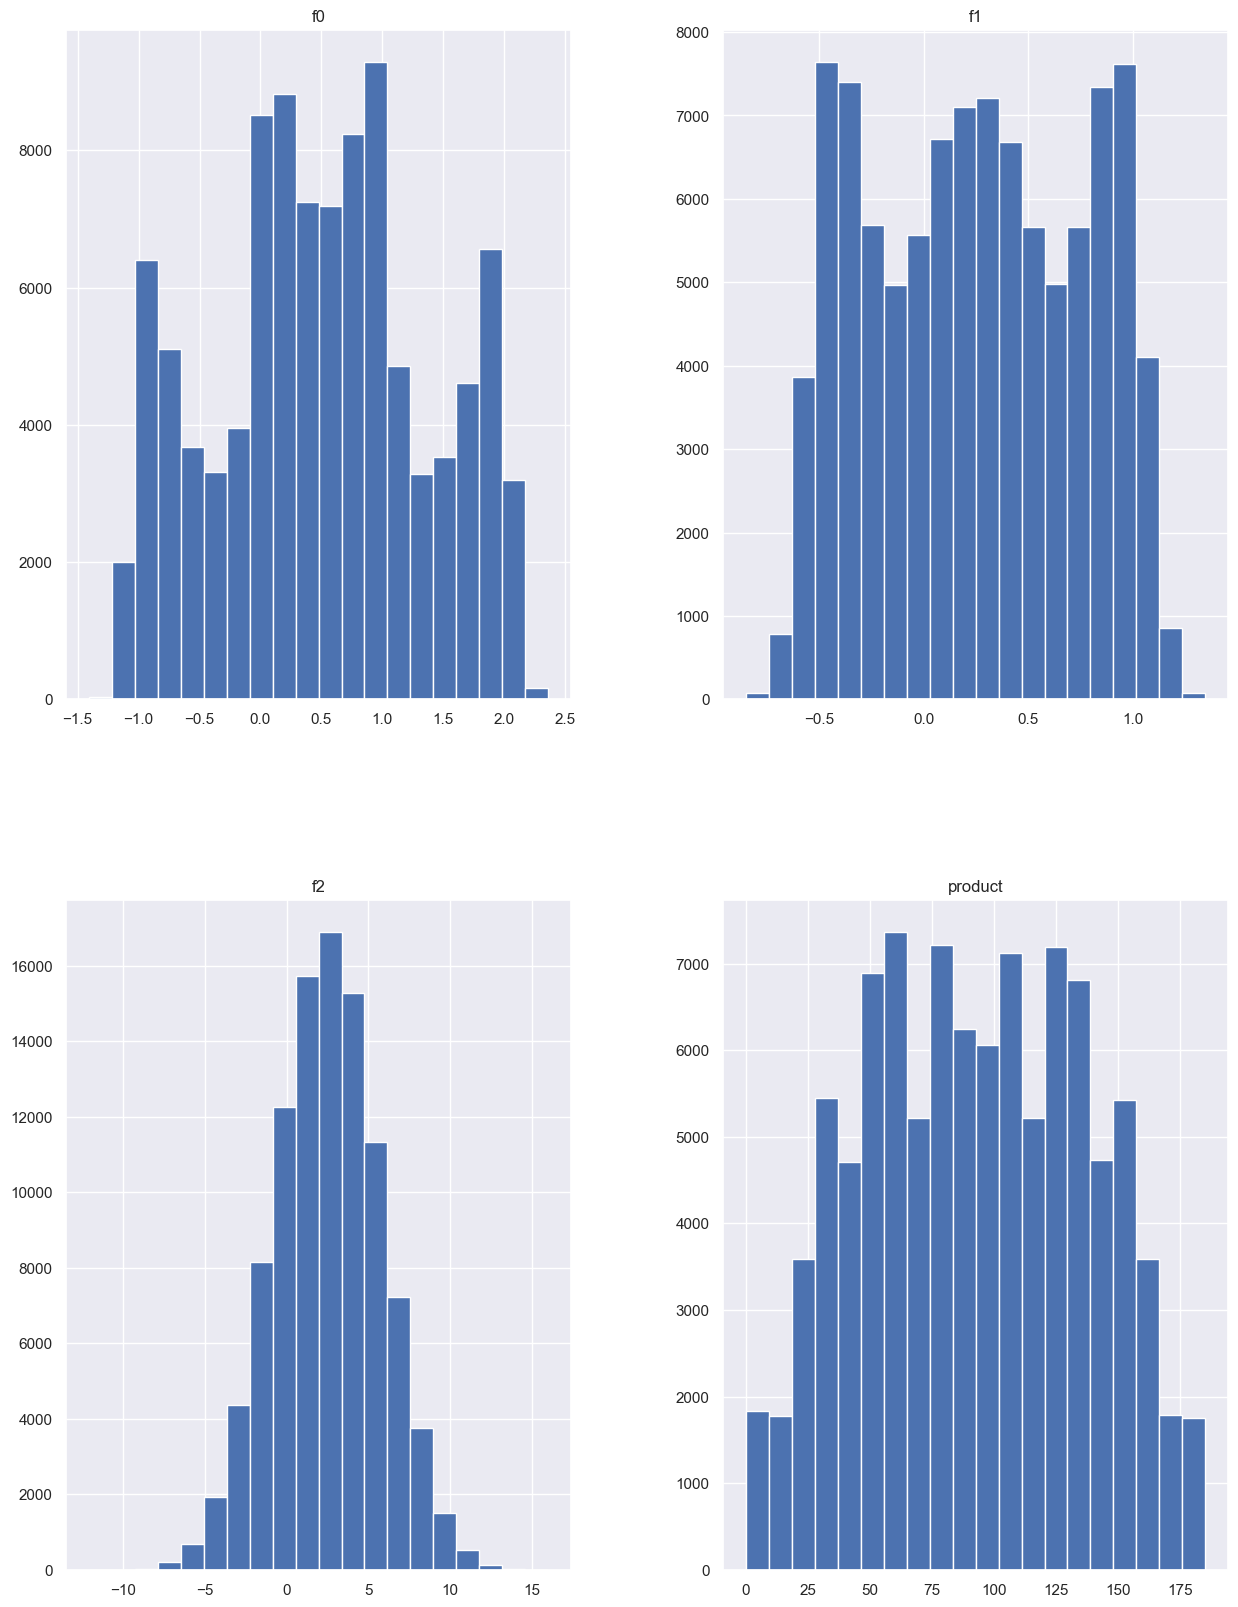

In [4]:
dataset_info(region_1)

- There are no gaps in the data.
- There are no complete duplicates.
- The distributions of all features look relatively normal.
- It is interesting to study the characteristics of the well(s) with zero reserves. Are these depleted deposits or errors in the data?

However, the first step is to change the name of the `product` feature in all three datasets so that the column can be accessed as follows: *data.column_name*. Since *product* is the name of a function, this method is not applicable to call a column, which creates some inconvenience.

In [5]:
region_1.rename(columns={'product': 'well_product'}, inplace=True)
region_2.rename(columns={'product': 'well_product'}, inplace=True)
region_3.rename(columns={'product': 'well_product'}, inplace=True)

Let's study the number of unique wells.

In [6]:
len(region_1.id.unique())

99990

In [7]:
region_1.id.value_counts().head(10)

fiKDv    2
QcMuo    2
AGS9W    2
Tdehs    2
74z30    2
A5aEY    2
bsk9y    2
TtcGQ    2
HZww2    2
bxg6G    2
Name: id, dtype: int64

In [8]:
region_1[region_1.id == 'TtcGQ']

,id,f0,f1,f2,well_product
60140,TtcGQ,0.569276,-0.104876,6.440215,85.350186
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008


It turns out that, with the exception of 10 wells, for which geological exploration was carried out twice, all other wells are unique. Let's get rid of duplicates, leaving the average values of features.

In [9]:
for well_id in region_1.id.value_counts().head(10).index:
    region_1.loc[region_1.id == well_id, ['f0', 'f1', 'f2', 'well_product']] = \
        region_1[region_1.id == well_id].mean(axis=0, numeric_only=True).values
    
region_1.drop_duplicates(subset='id', keep='first', inplace=True)

Consider a well(s) with zero reserves.

In [10]:
region_1[region_1.well_product == 0]

,id,f0,f1,f2,well_product
57263,zCM5W,-0.702064,0.375992,0.236572,0.0


There is only one, and the values of the features are not zero. That is, most likely, geological exploration really discovered its complete lack of prospects.

#### Region 2

GENERAL INFORMATION:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            100000 non-null  object 
 1   f0            100000 non-null  float64
 2   f1            100000 non-null  float64
 3   f2            100000 non-null  float64
 4   well_product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,well_product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



FIRST 10 ROWS:


,id,f0,f1,f2,well_product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408



DUPLICATES: 0

MISSING VALUES BY COLUMNS:

id              0
f0              0
f1              0
f2              0
well_product    0
dtype: int64

VALUES DISTRIBUTION BY COLUMNS:


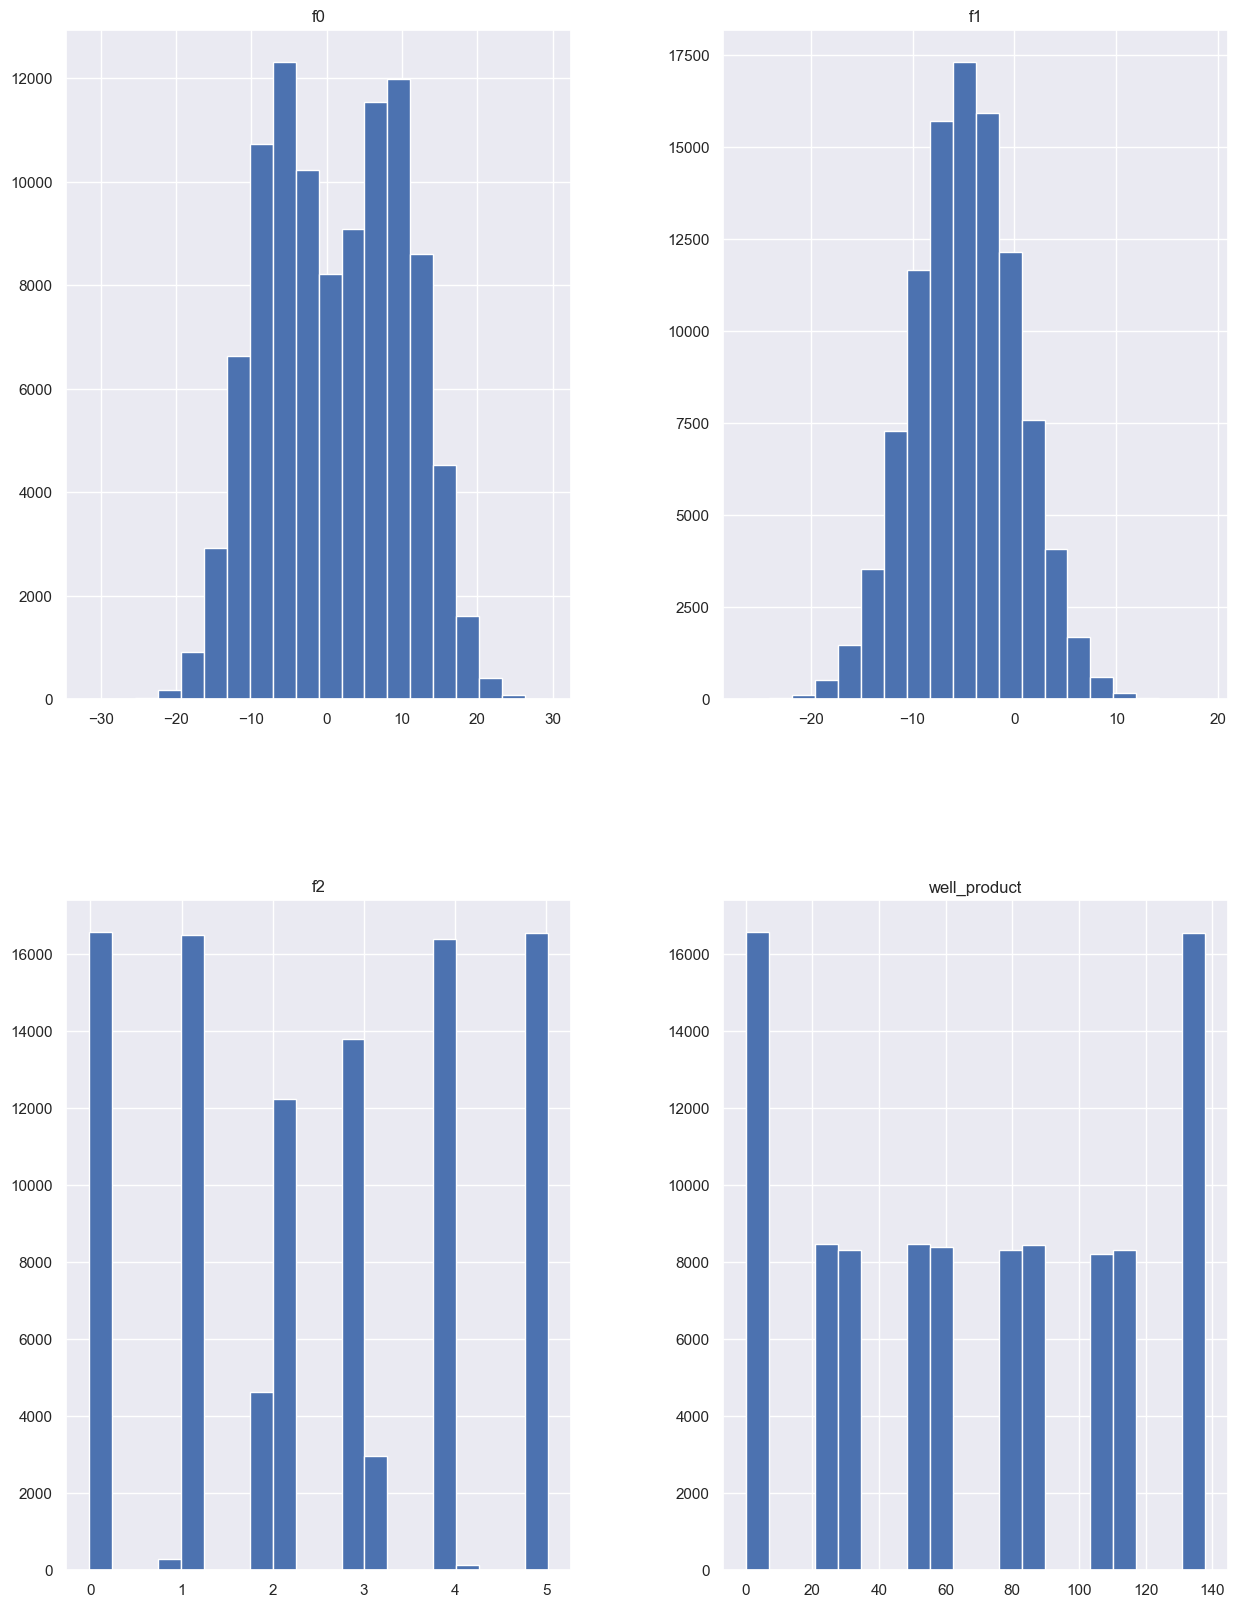

In [11]:
dataset_info(region_2)

- No complete duplicates and missing values.
- The dataset is represented by 100 thousand lines.
- The features `f2` and `well_product` are distributed extremely "non-randomly", we need to consider them in more detail.

In [12]:
len(region_2.id.unique())

99996

In [13]:
region_2.id.value_counts().head()

wt4Uk    2
LHZR0    2
5ltQ6    2
bfPNe    2
kBEdx    1
Name: id, dtype: int64

There are also several wells studied twice. We remove duplicates by writing the average of two measurements into the feature values.

In [14]:
for well_id in region_2.id.value_counts().head(4).index:
    region_2.loc[region_2.id == well_id, ['f0', 'f1', 'f2', 'well_product']] = \
        region_2[region_2.id == well_id].mean(axis=0, numeric_only=True).values
    
region_2.drop_duplicates(subset='id', keep='first', inplace=True)

Consider the distribution of feature values `f2` and `product`.

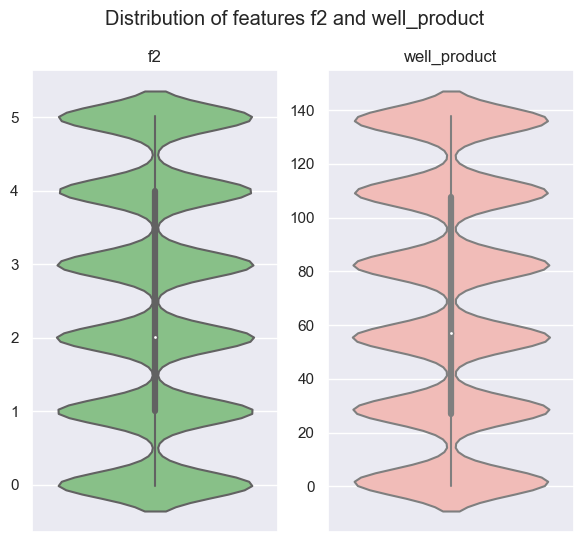

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(7, 6))
fig.suptitle('Distribution of features f2 and well_product')
sns.violinplot(ax=axs[0], data=region_2, y='f2', palette='Accent')
sns.violinplot(ax=axs[1], data=region_2, y='well_product', palette='Pastel1')

axs[0].set_title('f2')
axs[0].set_ylabel('')
axs[1].set_title('well_product')
axs[1].set_ylabel('')

plt.show()

For both signs, 6 groups of objects are visible with clear boundaries between categories, evenly distributed along the axis of values of these signs. Moreover, the number of objects in groups approximately coincides, and there is an extremely strong positive correlation between the `f2` feature and the target.

In [16]:
region_2.f2.corr(region_2.well_product)

0.99939697627093

With "zero" wells in the second region, the situation is more interesting. It is not alone, as in the case of region 1. There are as many as 8% of the total.

In [17]:
len(region_2[region_2.well_product == 0])

8235

Let's see how the feature `f2` is distributed only for "empty" wells.

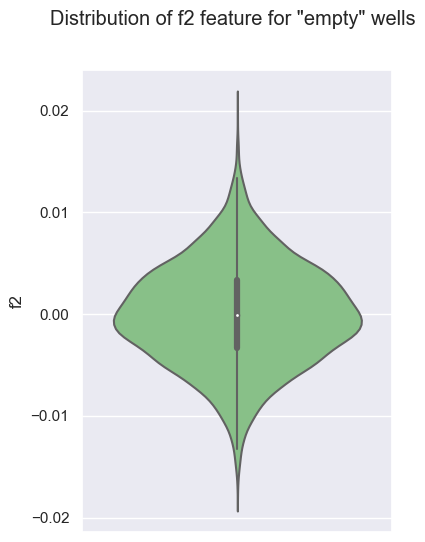

In [18]:
fig = plt.figure(figsize=(4, 6))
fig.suptitle('Distribution of f2 feature for "empty" wells')
sns.violinplot(data=region_2[region_2.well_product == 0], y='f2', palette='Accent')

plt.show()

For all of them, the value of the feature `f2` is zero with high accuracy.

#### Region 3

GENERAL INFORMATION:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            100000 non-null  object 
 1   f0            100000 non-null  float64
 2   f1            100000 non-null  float64
 3   f2            100000 non-null  float64
 4   well_product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,well_product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838



FIRST 10 ROWS:


,id,f0,f1,f2,well_product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532



DUPLICATES: 0

MISSING VALUES BY COLUMNS:

id              0
f0              0
f1              0
f2              0
well_product    0
dtype: int64

VALUES DISTRIBUTION BY COLUMNS:


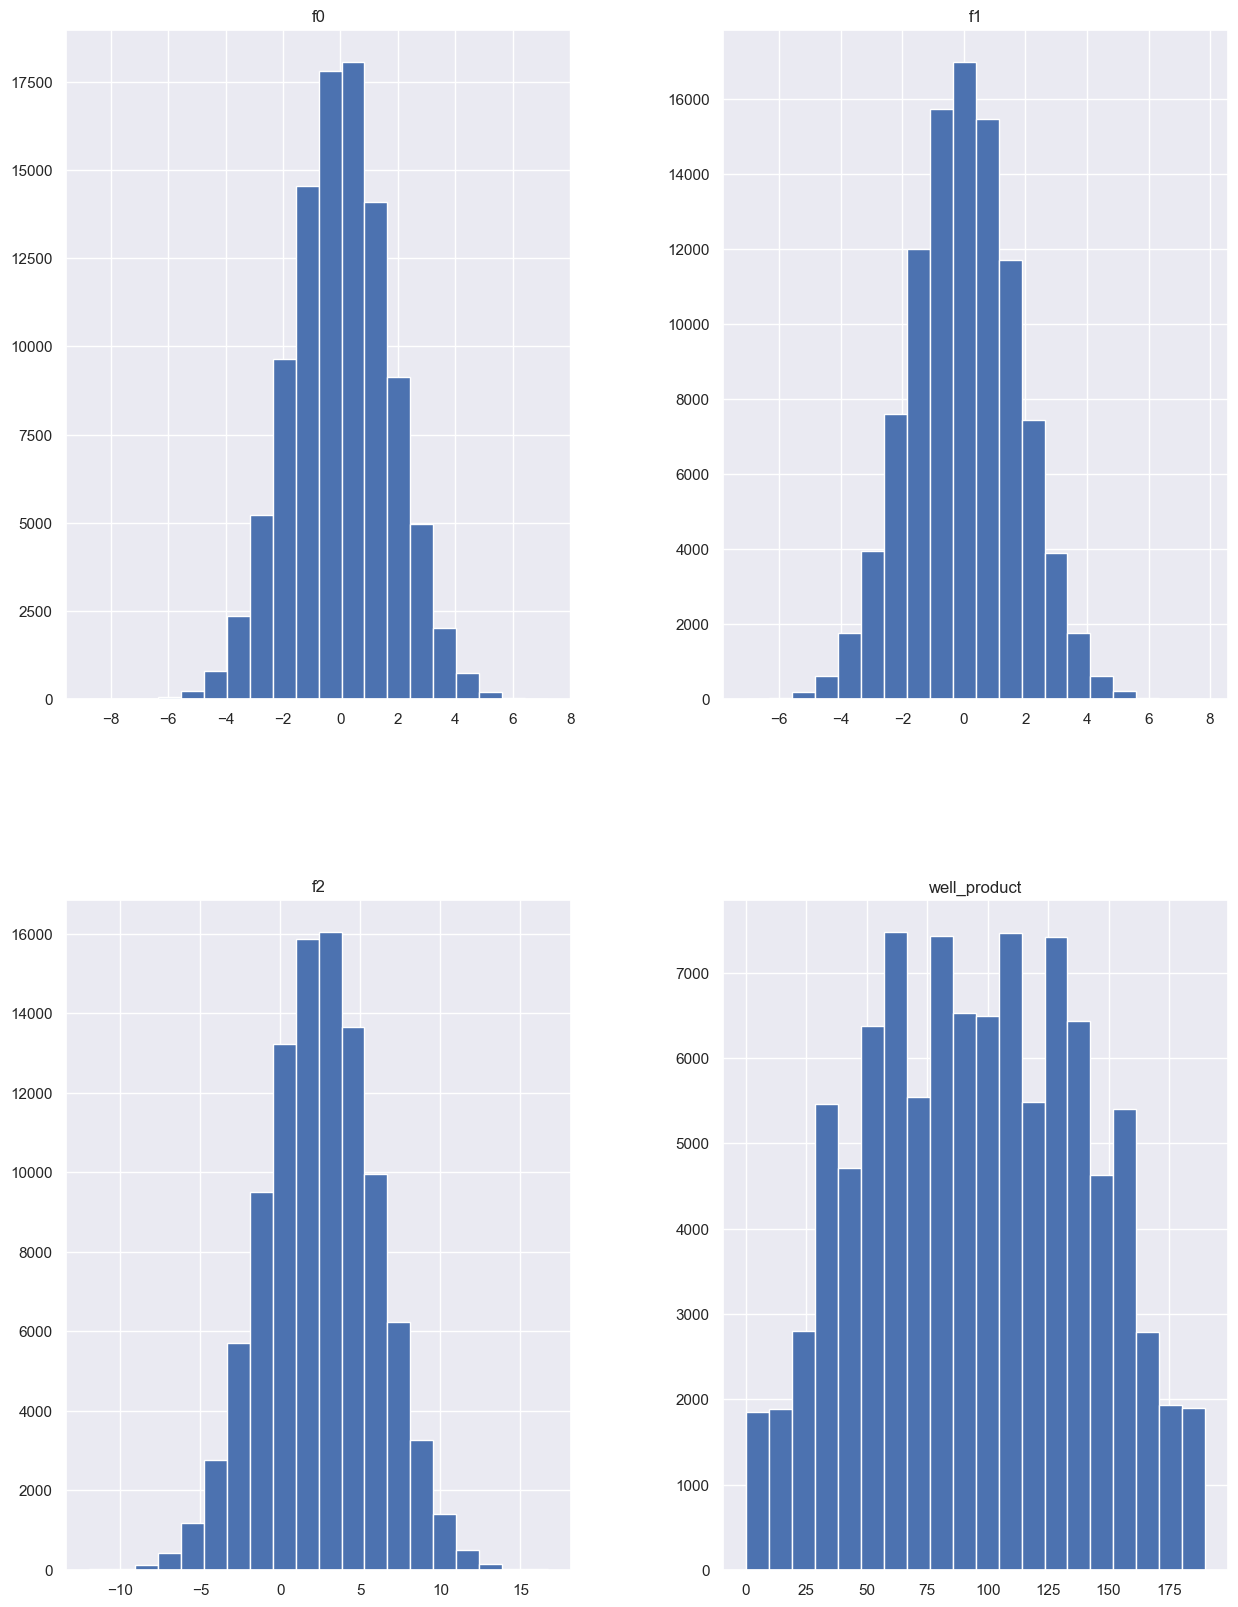

In [19]:
dataset_info(region_3)

- There are no gaps or complete duplicates in the data.
- The distributions of features look normal, the target has "tails cut off".

Let's check if there are duplicate wells here and process them in the same way if so.

In [20]:
len(region_3.id.unique())

99996

In [21]:
region_3.id.value_counts().head(4)

VF7Jo    2
KUPhW    2
xCHr8    2
Vcm5J    2
Name: id, dtype: int64

In [22]:
for well_id in region_3.id.value_counts().head(4).index:
    region_3.loc[region_3.id == well_id, ['f0', 'f1', 'f2', 'well_product']] = \
        region_3[region_3.id == well_id].mean(axis=0, numeric_only=True).values
    
region_3.drop_duplicates(subset='id', keep='first', inplace=True)

"Zero" wells:

In [23]:
region_3[region_3.well_product == 0]

,id,f0,f1,f2,well_product
68149,qeefd,-0.865596,-1.615247,-4.126441,0.0


Again, just one.

**To sum up,** we have three regions in which geological exploration was carried out. One of them - the second - strongly stands out among the rest by a large number of explored wells with zero reserves.

## Model training and validation

Let's prepare data for training models:
1. Exclude columns with well identification numbers from datasets.
2. Let's split the data into training and validation samples in the ratio of 75:25.
3. Separate the target feature from the rest.
4. Let's scale the numerical features.

According to the task, only a linear regression model is suitable for training.

In [24]:
def prepare_data_for_ml(dataset, target, redundant_features, test_split_size):
    
    # Excluding unnecessary features and divide the dataset into samples
    data_train, data_valid = train_test_split(
        dataset.drop(redundant_features, axis=1),
        test_size=test_split_size,
        random_state=36
    )
    
    # Separating features
    features_train = data_train.drop(target, axis=1)
    target_train = data_train[target]
    features_valid = data_valid.drop(target, axis=1)
    target_valid = data_valid[target]
    
    # Scaling numeric features
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    return features_train, target_train, features_valid, target_valid

### Region 1

In [25]:
features_1_train, target_1_train, features_1_valid, target_1_valid = prepare_data_for_ml(
    region_1,
    'well_product',
    'id',
    0.25
)

Let's train the model:

In [26]:
model_1 = LinearRegression()
model_1.fit(features_1_train, target_1_train)
preds_1 = model_1.predict(features_1_valid)

Model predictions:

In [27]:
print(f'Average stock of predicted raw materials (per well): {preds_1.mean():.3f}')
print(f'RMSE: {mse(target_1_valid, preds_1, squared=False):.3f}')

Average stock of predicted raw materials (per well): 92.515
RMSE: 37.886


To evaluate the result, you need to compare the model with a random one.
Let's create a list of model predictions that always gives the average value of the target feature as an answer.

In [28]:
preds_1_mean = [target_1_train.mean()]*len(target_1_valid)
print(f"Random model's RMSE: {mse(target_1_valid, preds_1_mean, squared=False):.3f}")

Random model's RMSE: 44.506


The possible deviation from the average stock of predicted raw materials is quite large (40%), but 15% better than the random model.

### Region 2

In [29]:
features_2_train, target_2_train, features_2_valid, target_2_valid = prepare_data_for_ml(
    region_2,
    'well_product',
    'id',
    0.25
)

Let's train the model:

In [30]:
model_2 = LinearRegression()
model_2.fit(features_2_train, target_2_train)
preds_2 = model_2.predict(features_2_valid)

Model predictions:

In [31]:
print(f'Average stock of predicted raw materials (per well): {preds_2.mean():.3f}')
print(f'RMSE: {mse(target_2_valid, preds_2, squared=False):.3f}')

Average stock of predicted raw materials (per well): 68.769
RMSE: 0.889


Here, there is not even a big need to compare the model with a random one: we had a feature that had a correlation coefficient of more than 0.99 with the target. The model will have very high accuracy. But nonetheless:

In [32]:
preds_2_mean = [target_2_train.mean()]*len(target_2_valid)
print(f"Random model's RMSE: {mse(target_2_valid, preds_2_mean, squared=False):.3f}")

Random model's RMSE: 45.813


The RMSE of the trained model is 98% less than that of the random one. At the same time, the average stock of predicted raw materials in this region is a quarter less than in the first one.

### Region 3

In [33]:
features_3_train, target_3_train, features_3_valid, target_3_valid = prepare_data_for_ml(
    region_3,
    'well_product',
    'id',
    0.25
)

Let's train the model:

In [34]:
model_3 = LinearRegression()
model_3.fit(features_3_train, target_3_train)
preds_3 = model_3.predict(features_3_valid)

Model predictions:

In [35]:
print(f'Average stock of predicted raw materials (per well): {preds_3.mean():.3f}')
print(f'RMSE: {mse(target_3_valid, preds_3, squared=False):.3f}')

Average stock of predicted raw materials (per well): 95.174
RMSE: 40.021


Compare with the result of a random model:

In [36]:
preds_3_mean = [target_3_train.mean()]*len(target_3_valid)
print(f"Random model's RMSE: {mse(target_3_valid, preds_3_mean, squared=False):.3f}")

Random model's RMSE: 44.797


The RMSE of the trained model is 10% less than that of the random one. The average stock of predicted raw materials practically coincides with the first region.

## Preparation for profit calculation

Let's save the key values for calculations in separate variables:

In [37]:
# Budget for well development in the region (RUB)
BUDGET = 10000000000

# The number of wells explored
EXP_WELLS_NUM = 500

# Number of wells selected for development
DEV_WELLS_NUM = 200

# Income from the sale of one thousand barrels of oil at the current price (rubles)
INCOME_PER_1K_BARRELS = 450000

# Maximum allowed loss probability (/ 100%)
MAX_LOSS_PROB = 0.025

# Model Predictions
preds_1 = pd.Series(preds_1, index=target_1_valid.index)
preds_2 = pd.Series(preds_2, index=target_2_valid.index)
preds_3 = pd.Series(preds_3, index=target_3_valid.index)

For the break-even development of a new well, it is necessary that the income from the sale of oil extracted from it exceeds the costs of its development. Let's calculate the minimum amount of raw materials that will ensure the fulfillment of this condition:
- Cost of development of one well (million rubles):

In [38]:
ONE_WELL_DEV_COST = BUDGET / DEV_WELLS_NUM
ONE_WELL_DEV_COST / 1000000

50.0

- The minimum volume of raw materials reserves, the sale of which will cover the cost of developing one well:

In [39]:
min_profitable_oil_vol = ONE_WELL_DEV_COST / INCOME_PER_1K_BARRELS
round(min_profitable_oil_vol, 2)

111.11

For all three regions, the average predicted volume of raw materials per well was less. Therefore, we need to be especially confident in the accuracy of volume predictions in wells that exceed the breakeven value. These deposits will form the basis of profits from the development of the region - we can't go wrong.

## Profit and Risk Calculation

Let's write a function for calculating the gross profit for the wells selected for development:

In [40]:
def gross_profit_calc(
    target,
    preds,
    budget,
    income_per_1k_barrels,
    dev_wells_num
):    
    preds_sorted = preds.sort_values(ascending=False)
    selected_wells = target[preds_sorted.index].iloc[:dev_wells_num]
    gross_profit = income_per_1k_barrels * selected_wells.sum() - budget
    
    return gross_profit

Let's calculate the risks and gross profit for each region. Using the bootstrap technique with 10,000 samples, we calculate the average profit, 95% confidence interval, and risk of loss.

### Region 1

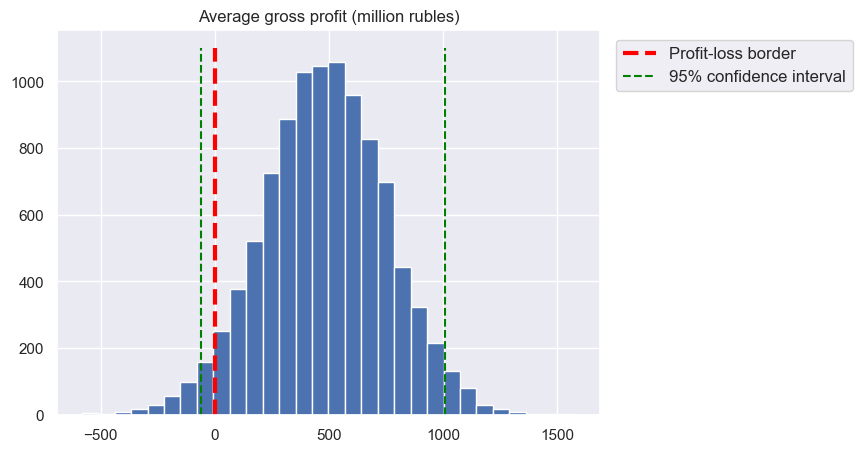

Average gross profit (million rubles): 482.68
Lower limit of the confidence interval (million rubles): -59.31
Loss probability: 3.86%


In [41]:
profit_values_1 = []

state = np.random.RandomState(36)

for i in range(10000):
    target_subsample = target_1_valid.sample(
        n=EXP_WELLS_NUM,
        replace=True,
        random_state=state
    )
    preds_subsample = preds_1[target_subsample.index]
    profit_values_1.append(
        gross_profit_calc(
            target_subsample,
            preds_subsample,
            budget=BUDGET, 
            income_per_1k_barrels=INCOME_PER_1K_BARRELS,
            dev_wells_num=DEV_WELLS_NUM
        )
    )
    
profit_values_1 = pd.Series(profit_values_1)

# Confidence interval limits, mean and probability of loss in a given region
lower_1 = profit_values_1.quantile(MAX_LOSS_PROB)
upper_1 = profit_values_1.quantile(1-MAX_LOSS_PROB)
mean_1 = profit_values_1.mean()
loss_count_1 = len(profit_values_1[profit_values_1 < 0])

# Output of bootstrap results
plt.figure(figsize=(7, 5))
plt.title('Average gross profit (million rubles)')

(profit_values_1 / 1000000).hist(bins=30);

plt.vlines(
    x=0, 
    ymin=0, ymax=1100, 
    linestyle='--', 
    colors='red', 
    linewidth=3, 
    label='Profit-loss border'
)
plt.vlines(
    x=[lower_1 / 1000000, upper_1 / 1000000], 
    ymin=0, ymax=1100, 
    linestyle='--', 
    colors='green',
    label='95% confidence interval'
)

plt.legend(loc=(1.03, 0.84), prop={'size': 12})
plt.show()

print(f'Average gross profit (million rubles): {mean_1 / 1000000:.2f}')
print(f'Lower limit of the confidence interval (million rubles): {lower_1 / 1000000:.2f}')
print(f'Loss probability: {loss_count_1 / 100:.2f}%')

### Region 2

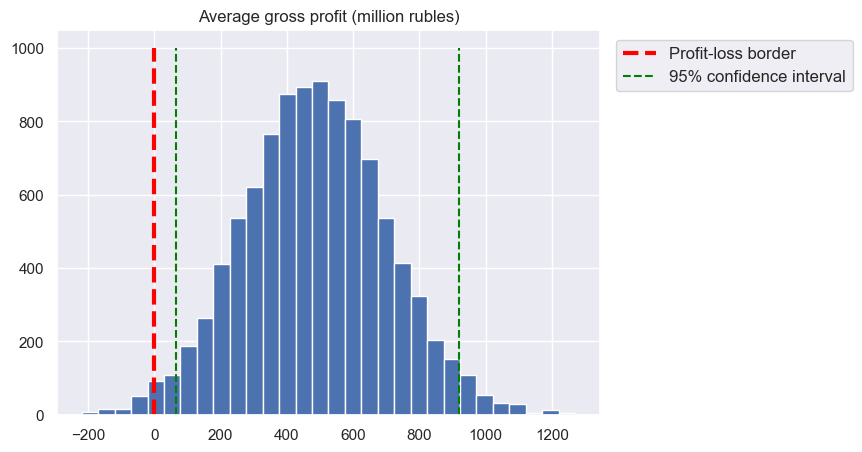

Average gross profit (million rubles): 485.95
Lower limit of the confidence interval (million rubles): 64.60
Loss probability: 1.22%


In [42]:
profit_values_2 = []

state = np.random.RandomState(36)

for i in range(10000):
    target_subsample = target_2_valid.sample(
        n=EXP_WELLS_NUM,
        replace=True,
        random_state=state
    )
    preds_subsample = preds_2[target_subsample.index]
    profit_values_2.append(
        gross_profit_calc(
            target_subsample,
            preds_subsample,
            budget=BUDGET, 
            income_per_1k_barrels=INCOME_PER_1K_BARRELS,
            dev_wells_num=DEV_WELLS_NUM
        )
    )
    
profit_values_2 = pd.Series(profit_values_2)

# Confidence interval limits, mean and probability of loss in a given region
lower_2 = profit_values_2.quantile(MAX_LOSS_PROB)
upper_2 = profit_values_2.quantile(1-MAX_LOSS_PROB)
mean_2 = profit_values_2.mean()
loss_count_2 = len(profit_values_2[profit_values_2 < 0])


# Output of bootstrap results
plt.figure(figsize=(7, 5))
plt.title('Average gross profit (million rubles)')

(profit_values_2 / 1000000).hist(bins=30);

plt.vlines(
    x=0, 
    ymin=0, ymax=1000, 
    linestyle='--', 
    linewidth=3,
    colors='red', 
    label='Profit-loss border'
)
plt.vlines(
    x=[lower_2 / 1000000, upper_2 / 1000000], 
    ymin=0, ymax=1000, 
    linestyle='--', 
    colors='green',
    label='95% confidence interval'
)

plt.legend(loc=(1.03, 0.84), prop={'size': 12})
plt.show()

print(f'Average gross profit (million rubles): {mean_2 / 1000000:.2f}')
print(f'Lower limit of the confidence interval (million rubles): {lower_2 / 1000000:.2f}')
print(f'Loss probability: {loss_count_2 / 100:.2f}%')

### Region 3

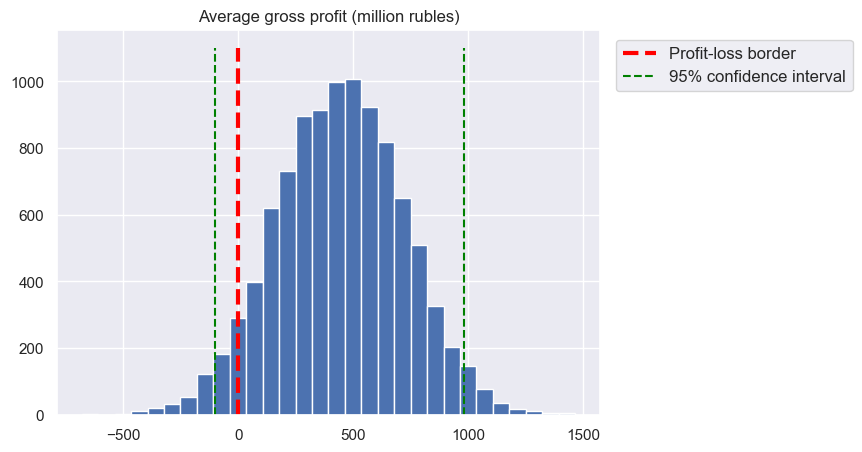

Average gross profit (million rubles): 441.70
Lower limit of the confidence interval (million rubles): -100.78
Loss probability: 5.46%


In [43]:
profit_values_3 = []

state = np.random.RandomState(36)

for i in range(10000):
    target_subsample = target_3_valid.sample(
        n=EXP_WELLS_NUM,
        replace=True,
        random_state=state
    )
    preds_subsample = preds_3[target_subsample.index]
    profit_values_3.append(
        gross_profit_calc(
            target_subsample,
            preds_subsample,
            budget=BUDGET, 
            income_per_1k_barrels=INCOME_PER_1K_BARRELS,
            dev_wells_num=DEV_WELLS_NUM
        )
    )
    
profit_values_3 = pd.Series(profit_values_3)

# Confidence interval limits, mean and probability of loss in a given region
lower_3 = profit_values_3.quantile(MAX_LOSS_PROB)
upper_3 = profit_values_3.quantile(1-MAX_LOSS_PROB)
mean_3 = profit_values_3.mean()
loss_count_3 = len(profit_values_3[profit_values_3 < 0])


# Output of bootstrap results
plt.figure(figsize=(7, 5))
plt.title('Average gross profit (million rubles)')

(profit_values_3 / 1000000).hist(bins=30);

plt.vlines(
    x=0, 
    ymin=0, ymax=1100, 
    linestyle='--', 
    linewidth=3,
    colors='red', 
    label='Profit-loss border'
)
plt.vlines(
    x=[lower_3 / 1000000, upper_3 / 1000000], 
    ymin=0, ymax=1100, 
    linestyle='--', 
    colors='green',
    label='95% confidence interval'
)

plt.legend(loc=(1.03, 0.84), prop={'size': 12})
plt.show()

print(f'Average gross profit (million rubles): {mean_3 / 1000000:.2f}')
print(f'Lower limit of the confidence interval (million rubles): {lower_3 / 1000000:.2f}')
print(f'Loss probability: {loss_count_3 / 100:.2f}%')

## Conclusion

We had at our disposal samples of oil and the volume of its reserves in three regions, 100,000 wells in each.
After cleaning the data from duplicates and its preprocessing, we built a machine learning model that helped determine the region where mining will bring the greatest profit - **Region 2**. It has:
- the largest average gross profit among the regions based on the results of the bootstrap (495.95 million rubles);
- the lowest risk of loss (1.22%).